In [1]:
#Imports
import sys
sys.path.append('../python/')
import NGC5533_functions_newmag as nf

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
import lmfit as lm
import dataPython as dp
import scipy.interpolate as inter

from datetime import datetime
import scipy.integrate as si
import noordermeer as noord
import time

# PLEASE NOTE THAT THIS WILL BECOME
# OBSOLETE ONCE WE HAVE RESOLVED
# THE ISSUES WITH THE LUMINOSITY.
# AT THAT TIME, THIS FILE SHOULD BE
# DELETED AND THE ORIGINAL FILE
# SHOULD BE RERUN IF NECESSARY

If you do, DISCARD ALL CHANGES TO THE FILE.
Your calculations will NOT be consistent with this library's equations if you use the disk.hdf5 or bulge.hdf5 files,
and if you write to that file it will contain calculations based on conflicting constants.
Worst case scenario, reset the disk.hdf5 file to before the commit where you used this library to write to it.


In [2]:
#****************
#Noord Data points
#****************
starttime = time.time()

data = dp.getXYdata_wXYerr('data/final/nord-120kpc-datapoints_sorted.txt')
data_total = dp.getXYdata('data/final/nord-120kpc-total.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

In [3]:
#****************
#Uncertainty Band
#****************

rval = np.arange(0.1,200,0.1)
# make an empty array for a new velocity array to store velocity that's below 300 km/s 
# it seems Noordermeer ignored those points
v_dat_below300 = []

# when v_dat is above 300 km/s, replace it with 273 km/s
# average didn't seem to work as well
for v in range(len(v_dat)):
    if v_dat[v] < 300.0:
        v_dat_below300.append(v_dat[v])
    else:
        v_dat_below300.append(273)
        #v_dat_average = (v_dat[v-2] + v_dat[v+2])/2
        #v_dat_below300.append(v_dat_average)

# convert list to array
v_dat_below300 = np.array(v_dat_below300)

#print(v_dat_below300)

# this is just a guess for a delta_i that's changing with radius
#delta_i = 3+r_dat/4
delta_i = 3

# eq 4.2 on pg 168 in Noordermeer's thesis
#v_i = (v_dat_below300 / np.tan(52*(np.pi/180)) * delta_i *(np.pi/180))
v_i = (v_dat / np.tan(52*(np.pi/180)) * delta_i *(np.pi/180))

# define grey band
greyb_below = v_dat_below300-v_i
greyb_above = v_dat_below300+v_i

# spline grey band
tb,cb,kb = inter.splrep(r_dat,greyb_below)
ta,ca,ka = inter.splrep(r_dat,greyb_above)
greyb_below_spline = inter.BSpline(tb,cb,kb)
greyb_above_spline = inter.BSpline(ta,ca,ka)


# spline points
points_spline = inter.UnivariateSpline(r_dat, v_dat_below300, k=4)

points_polyfit = np.polyfit(r_dat, v_dat, 3)
print(points_polyfit)

z = lambda x: points_polyfit[3] + points_polyfit[2]*x + points_polyfit[1]*x**2 + points_polyfit[0]*x**3

zgreyb_below = z(r_dat)-v_i
zgreyb_above = z(r_dat)+v_i

print(len(r_dat))

#change r_dat so it's strictly increasing
r_dat, v_dat, v_err0, v_err1 = (np.asarray(list(a)) for a in zip(*sorted(zip(r_dat, v_dat, v_err0, v_err1))))
#converting v_err1 to an array
#v_err1_array = np.asarray(v_err1)

band = (zgreyb_above - zgreyb_below)/2
#Express as weights
weighdata = 1/(np.sqrt((v_err1**2)+(band**2)))

[ 1.73859698e-04 -2.05476507e-02 -2.02607801e-01  2.81668330e+02]
69


C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\interpolate\fitpack2.py:226: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


In [4]:
#****************
#gas component
#****************

# parameters
c0 = 6                      #concentration parameter
A = 30                      #centroid velocity amplitude (km/s)
p = 1                       #This parameter was fixed at p = 1, which corresponds to an asymptotically flat rotation curve at large radii

def v(r):
    A = 30 #something is getting overwritten somewhere.
    p = 1
    c0 = 6
    return A*r/((r**2 + c0**2)**(p/2))

g_v1 = np.vectorize(v)


In [5]:
# Function for fitting only prefactors + halo's parameters + data thief
def g(r,M,rc,rho00,c,pref,gpref):
    return np.sqrt(nf.bh_v(r,M,load=True)**2 
                   + nf.h_v(r,rc,rho00,load=True)**2 
                   + c**2*nf.b_v(r,load=False,save=False)**2 
                  # + pref**2*nf.d(r,load=False,save=False)**2
                   + gpref**2*g_v1(r)**2)

#print(g(1,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1))
#print(g(5,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1))

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: Inte

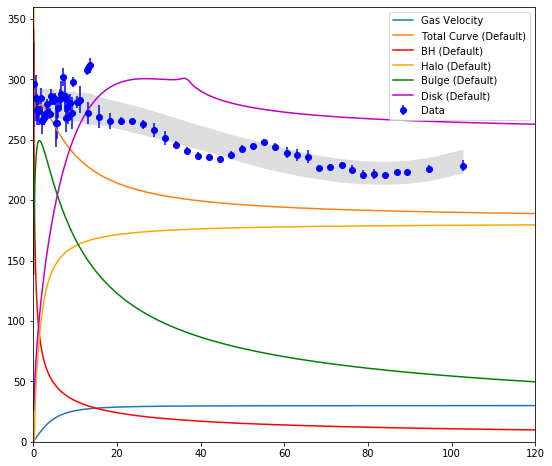

In [6]:
#Plot 

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,120)
plt.ylim(0,360)

rval = np.arange(0.1,200,0.1)

plt.plot(rval, g_v1(rval), linestyle='solid', label='Gas Velocity') #gas
plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')
plt.plot(rval,nf.bh_v(rval,load=True),color='r',label='BH (Default)')
plt.plot(rval,nf.h_v(rval,load=True),color='orange',label='Halo (Default)')
plt.plot(rval,nf.b_v(rval,load=False,save=False),color='g',label='Bulge (Default)')
plt.fill_between(r_dat,zgreyb_below,zgreyb_above,color='#dddddd')
plt.plot(rval,nf.d_v(rval,load=False,save=False),color='m',label='Disk (Default)')

plt.legend()
#plt.savefig('Fitting_allcomponents_125kpc.png')
plt.show()

In [7]:
# Fit, using prefactors

#Setup
g_mod = lm.Model(g)
g_params = g_mod.make_params()
#Black Hole
g_params.add('M', value=nf.Mbh_def, min=0) #Mass
#Halo
g_params.add('rc', value=nf.h_rc, min=0.1)   #Radius (magnitude)
g_params.add('rho00', value=nf.hrho00_c, min=0) #Density (halo)

#Bulge
g_params.add('c', value=1,min=0,max=100)          #Contributions should all add
#Disk
g_params.add('pref', value=1,min=0, max=100)

#gas
g_params.add('gpref', value=1,min=0, max=100)

#Do fit
g_fit = g_mod.fit(v_dat,g_params,r=r_dat,weights=weighdata)

#Define for plotting

bestg = g_fit.best_fit
#delg = g_fit.eval_uncertainty() #Currently broken -- appears that pars[pname].stderr is type "None".

In [8]:
print('Fit information for all-component fit, prefactor:')
g_fit

Fit information for all-component fit, prefactor:


In [9]:
'''

print(g_fit.nfev)
# print number of data points
print(g_fit.ndata)
# print number of variables
print(g_fit.nvarys)
# chi-sqr
print(g_fit.chisqr)
# reduce chi-sqr
print(g_fit.redchi)
#Akaike info crit
print(g_fit.aic)
#Bayesian info crit
print(g_fit.bic)
'''
data_points = str(g_fit.nfev)
data_points = str(g_fit.nfev).join(data_points)

import csv
with open('latex_tables/LmFit_statistics_true_fit.csv','w',newline='') as f:
    thewriter = csv.writer(f)
    
    thewriter.writerow(['col1','col2'])
    thewriter.writerow(['Number of Function Evaluations',str(g_fit.nfev)])
    thewriter.writerow(['Number of Data Points',str(g_fit.ndata)])
    thewriter.writerow(['Number of Variables',str(g_fit.nvarys)])
    thewriter.writerow(['Reduced X^2',str(round(g_fit.redchi,3))])

#print(g_fit.params)

In [10]:
#File writing
file = open("latex_tables/table_true.tex","w")
file.write("\\begin{tabular}[c]{| c | c | c | c | c | c | c | c |} \n")
file.write("\hline \n")
file.write("    \\textbf{Parameter} & \\textbf{Units} & \\textbf{Value} & \\textbf{Standard Error} & \\textbf{Relative Error} & \\textbf{Initial Value} & \\textbf{Min} & \\textbf{Max} \\\ \hline \n")
#If we want to use units different from what the notebook uses, division will need to occur in the following lines.
M_stderr = g_fit.params['M'].stderr
file.write("    M & M$_\\odot$ & " 
           + "{:.2e}".format(g_fit.best_values['M']) + " & " 
           + "{:.2e}".format(M_stderr) + " & " 
           + str(int(M_stderr / g_fit.best_values['M'] * 100)) + "\% & "
           + "{:.2e}".format(g_fit.init_values['M']) + " & " 
           + "{:.2e}".format(g_params['M'].min) + " & "
           + str(g_params['M'].max)
           + " \\\ \\hline \n")
rc_stderr = g_fit.params['rc'].stderr
file.write("    r$_c$ & kpc & " 
           + str(round(g_fit.best_values['rc'],2)) + " & " 
           + str(round(rc_stderr,2)) + " & " 
           + str(int(rc_stderr / g_fit.best_values['rc'] * 100)) + "\% & "
           + str(g_fit.init_values['rc']) + " & " 
           + str(g_params['rc'].min) + " & "
           + str(g_params['rc'].max)
           + " \\\ \\hline \n")
rho00_stderr = g_fit.params['rho00'].stderr
file.write("    $\\rho_{00}$ & kpc & " 
           + "{:.2e}".format(g_fit.best_values['rho00']) + " & " 
           + "{:.2e}".format(rho00_stderr) + " & " 
           + str(int(rho00_stderr / g_fit.best_values['rho00'] * 100)) + "\% & "
           + "{:.2e}".format(g_fit.init_values['rho00']) + " & " 
           + str(g_params['rho00'].min) + " & "
           + str(g_params['rho00'].max)
           + " \\\ \\hline \n")
c_stderr = g_fit.params['c'].stderr
file.write("    Bulge Prefactor & - & " 
           + str(round(g_fit.best_values['c'],2)) + " & " 
           + str(round(c_stderr,2)) + " & " 
           + str(int(c_stderr / g_fit.best_values['c'] * 100)) + "\% & "
           + str(g_fit.init_values['c']) + " & " 
           + str(g_params['c'].min) + " & "
           + str(g_params['c'].max)
           + " \\\ \\hline \n")
pref_stderr = g_fit.params['pref'].stderr
file.write("    Disk Prefactor & - & " 
           + str(round(g_fit.best_values['pref'],2)) + " & " 
           + str(round(pref_stderr,2)) + " & " 
           + str(int(pref_stderr / g_fit.best_values['pref'] * 100)) + "\% & "
           + str(g_fit.init_values['pref']) + " & " 
           + str(g_params['pref'].min) + " & "
           + str(g_params['pref'].max)
           + " \\\ \\hline \n")
file.write("\\end{tabular} \n")

file.close()

TypeError: unsupported format string passed to NoneType.__format__

In [ ]:
#Plot to 110kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,110)
plt.ylim(0,350)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,bestg,'r-',label='Fit components (prefactors)(125kpc)')
plt.fill_between(r_dat,zgreyb_below,zgreyb_above,color='#dddddd')

plt.legend()
#plt.savefig('Fitting_allcomponents_125kpc.png')
plt.show()

In [ ]:
#Plot to 25kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,25)
plt.ylim(0,325)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,bestg,'r-',label='Fit components (prefactors)(25kpc)')
plt.fill_between(r_dat,zgreyb_below,zgreyb_above,color='#dddddd')
#plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')

plt.legend()
#plt.savefig('Fitting_allcomponents_25kpc.png')
plt.show()

In [ ]:
# Total curve
# convert to numpy arrays
r_total = np.asarray(data_total['xx'])
v_total = np.asarray(data_total['yy'])

# smoothing - new, `spline` would not run on my computer
t, c, k = inter.splrep(r_total,v_total)
f_v_total = inter.BSpline(t,c,k)

#f_v_total = inter.spline(r_total,v_total,rval,kind='smoothest')


#Plot to 120kpc
fig, axs = plt.subplots(2,1,figsize=(14,10))
#fig = plt.figure(figsize=(14,10.0))

#plt.xlim(0,20)
#plt.ylim(0,360)


ax1 = axs[0]
ax1.errorbar(r_dat,v_dat,yerr=v_err1,color='k',fmt='s',markerfacecolor='none',label='Data')
ax1.plot(rval, f_v_total(rval), color='k', linewidth=5,label='Noordermeer (2008)') 
ax1.plot(r_dat,bestg,'r-',linewidth=3,label='Reproduced')
ax1.set_xlim([0, 110])
ax1.set_ylim([200, 360])
ax1.legend(loc="upper right", prop={'size': 20})

ax2 = axs[1]
ax2.errorbar(r_dat,v_dat,yerr=v_err1,color='k',fmt='s',markerfacecolor='none',label='Data')
plt.plot(rval, f_v_total(rval), color='k', linewidth=5,label='Noordermeer (2008)') 
plt.plot(r_dat,bestg,'r-',linewidth=3,label='Reproduced')
ax2.set_xlim([0, 20])
ax2.set_ylim([200, 360])



#plt.fill_between(rval,greyb_bottom(rval),greyb_top(rval),color='#dddddd')
#plt.fill_between(r_dat,bestg-delg,bestg+delg,color='#dddddd')

fig.text(0.5, 0.08, 'Radius [kpc]', ha='center', va='center',fontsize=20)
fig.text(0.08, 0.5, 'Velocity [km/s]', ha='center', va='center', rotation='vertical',fontsize=20)
fig.suptitle('Total Curve Fitting Using All Models (No Tracing)', fontsize=30,y=.93)
#plt.set_title('Total Rotation Curve Fitting Results', fontsize=20) 


#plt.savefig('Reproducibility_Paper_Figures/real_total_fitting_results.png')#don't overwrite during test

In [ ]:
#Define for plotting cont.

g_dict = g_fit.best_values
g_M = g_dict['M']
g_c = g_dict['c']
g_pref = g_dict['pref']
g_rc = g_dict['rc']
g_hrho00 = g_dict['rho00']
g_gpref = g_dict['gpref']

g_curve = g(rval,g_M,g_rc,g_hrho00,g_c,g_pref,g_gpref)
bh_curve = nf.bh_v(rval,g_M)
halo_curve = nf.h_v(rval,g_rc,g_hrho00)
bulge_curve = g_c*nf.b_v(rval, load=True)
disk_curve = g_pref*nf.d_v(rval, load=False,save=False)
gas_curve = g_gpref*g_v1(rval)

In [ ]:
#Plot each fitted component to 100kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,100)
plt.ylim(0,350)
plt.plot(rval,g_curve,'r-',label='Total Fit')
plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')


#plt.fill_between(r_dat,bestg-delg,bestg+delg,color='#dddddd',label='Uncertainty Band')
plt.plot(rval,bh_curve,'green',label='Blackhole')
plt.plot(rval,halo_curve,'yellow',label='Halo')
plt.plot(rval,bulge_curve,'cyan',label='Bulge')
plt.plot(rval,disk_curve,'magenta',label='Disk (Noordermeer)')
plt.plot(rval,gas_curve,'black',label='Gas [Static] (Noordermeer)')
plt.fill_between(r_dat,zgreyb_below,zgreyb_above,color='#dddddd')


#plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')

plt.legend()
#plt.savefig('Fitting_allcomponents_100kpc.png')
plt.show()

In [ ]:
#Plot each fitted component to 20kpc

fig = plt.figure(figsize=(9.0,8.0))

plt.xlim(0,2.5)
plt.ylim(0,350)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
#plt.plot(r_dat,l_curve,'b-',label='Fit components (all) (25kpc)')

plt.plot(rval,g_curve,'r-',label='Fit components (prefactors)(20kpc)')
plt.plot(rval,bh_curve,'green',label='Black Hole curve (fit)')
plt.plot(rval,halo_curve,'yellow',label='Halo curve (fit)')
plt.plot(rval,bulge_curve,'cyan',label='Bulge curve (fit)')
plt.plot(rval,disk_curve,'magenta',label='Disk curve (fit using Noordermeer disk)')
plt.plot(rval,gas_curve,'black',label='Gas curve (fit using Noordermeer gas)')

plt.plot(rval,g(rval,nf.Mbh_def,nf.h_rc,nf.hrho00_c,1,1,1),label='Total Curve (Default)')

plt.legend()
#plt.savefig('Fitting_allcomponents_20kpc.png')
plt.show()

In [ ]:
# Explanation of parameters 

# Bulge
print('Bulge')
print('Scaling constant,         C = {:.2f}'.format(g_c))

print('')


# Disk
print('Disk')
print('Scaling constant,         prefactor = {:.3f}'.format(g_pref))

print('')


# Black Hole
print('Black Hole')
print('Mass of the Black Hole,   M(bh) = {:.3e} [solar masses]'.format(g_M))
print('')


# Dark Halo
print('Dark Halo')
print('Halo central density,     rho00 = {:.3e} [solar mass/kpc^3]'.format(g_hrho00))
print('Core radius,              rc = {:.2f} [kpc]'.format(g_rc))


In [ ]:
endtime = time.time()     #put this at end of code
print('Total Time:')
runtime = endtime - starttime

if runtime<=60:
    minutes, runtime= divmod(runtime, 60)
    print(str(round(runtime))+'s')
elif runtime>60 and runtime<=3600:
    minutes, runtime= divmod(runtime, 60)
    print(str(round(minutes))+'min', str(round(runtime))+'s')
elif runtime>3600 and runtime<=86400:
    minutes = runtime/60
    hours, minutes= divmod(minutes, 60)
    print(str(round(hours))+'hrs', str(round(minutes))+'min')
elif runtime>86400:
    hours = runtime/3600
    days, hours= divmod(hours, 24)
    print(str(round(days))+'days', str(round(hours))+'hrs')